In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('../app/data/total.csv')

    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [2]:
data.head(3)

,JobTitle,Company,Location,Pay,ExtractDate,PostDate,Requirements,Summary,Description,JobUrl,Salary
0,Lead ETL Developer,IQVIA,"Malvern, PA 19355",NaN,2021-07-10,Just posted,None,Bachelor’s Degree or higher. You will particip...,"Lead ETL Software DeveloperOMOP Factory, Real ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN
1,Data Scientist,Thermo Fisher Scientific,"Austin, TX 73301 (St Edwards area)+2 locations...",NaN,2021-07-10,Just posted,None,Proficiency with data analysis languages and t...,Thermo Fisher Scientific Inc. is the world lea...,https://www.indeed.com/rc/clk?jk=f896d8db81cb8...,NaN
2,Senior Data Scientist,Tokio Marine HCC- Public Risk Group,Remote•Remote,"From $100,000 a year",2021-07-10,Just posted,None,"Python, R or similar data analysis programming...",None,https://www.indeed.com/rc/clk?jk=701bf5b2205b2...,NaN


In [3]:
null = sum(data.Pay.isnull())
nnull = sum(data.Pay.notnull())
print(data.isnull().sum())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')

JobTitle            0
Company             0
Location            0
Pay             32755
ExtractDate         0
PostDate            0
Requirements        0
Summary             0
Description         0
JobUrl              0
Salary          36186
dtype: int64

The data contains 36272 rows of individual job postings with values for 11 columns based on
 different sections of each post's web page.

- Out of 36272 job postings 3517 or 9.7% include some sort of salary information,
- The remaining 32755 rowws, or 90.3% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


In [4]:
print('Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I\'ll extract\n the remaing non-numeric chars into a new column that\'ll allow me to build the annual Salary column once the remaining\n numeric string are converted to floating point.')

samples = []
for i in np.unique(data[data['Pay'].notnull()].Pay):
    samples.append(i)
samples[:5]



Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I'll extract
 the remaing non-numeric chars into a new column that'll allow me to build the annual Salary column once the remaining
 numeric string are converted to floating point.


['$1,500 - $5,000 a month',
 '$1,673 - $3,303 a week',
 '$10 - $15 an hour',
 '$10 an hour',
 '$10,000 - $50,000 a year']

In [5]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)


def munge():
    """[Cleaning and Featuring Engineering]

    Args:
        position ([string]): [identifier for scraped dataset]

    Returns:
        [csv]: [data prepared for ML]
    """
    # Using the position variable to select/process scraped data based the on the query that
    # generated it.
    data = pd.read_csv('../app/data/total.csv', index_col=1)
    data = data[data.Pay != '30+ days ago']
    data = data[data.Pay != '$120 per student']

    #TODO just name is salary in scrape.py

    

    def states_(data):
        """[Builds 'State' feature by splitting 'Location']

        Args:
            i ([row of data]): ['Location' value]

        Returns:
            [string]: [state name abbrieviation]
        """
        states = {" AL":"Alabama", " AK":"Alaska", " AS":"American Samoa", " AZ":"Arizona", " AR":"Arkansas",
        " CA":"California", " CO":"Colorado", " CT":"Connecticut", " DE":"Delaware", " DC":"District of Columbia",
        " FL":"Florida", " GA":"Georgia", " GU":"Guam ", " HI":"Hawaii", " ID":"Idaho", " IL":"Illinois", " IN":"Indiana",
        " IA":"Iowa", " KS":"Kansas", " KY":"Kentucky", " LA":"Louisiana", " ME":"Maine", " MD":"Maryland", " MA":"Massachusetts",
        " MI":"Michigan", " MN":"Minnesota", " MS":"Mississippi", " MO":"Missouri", " MT":"Montana", " NE":"Nebraska",
        " NV":"Nevada", " NH":"New Hampshire", " NJ":"New Jersey", " NM":"New Mexico", " NY":"New York", " NC":"North Carolina",
        " ND":"North Dakota", " MP":"Northern Mariana Islands", " OH":"Ohio", " OK":"Oklahoma", " OR":"Oregon", " PA":"Pennsylvania",
        " PR":"Puerto Rico", " RI":"Rhode Island", " SC":"South Carolina", " SD":"South Dakota", " TN":"Tennessee",
        " TX":"Texas", " UT":"Utah", " UM":"U.S. Minor Outlying Islands", " VT":"Vermont", " VI":"Virgin Islands", " VA":"Virginia",
        " WA":"Washington", " WV":"West Virginia", " WI":"Wisconsin", " WY":"Wyoming"}
        extras = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
        for k,v in states.items():
            data['State'] = np.where(data['Location'].str.contains(k), k, data['State'])
            data['State'] = np.where(data['Location'].str.contains(v), k, data['State'])
            data['State'] = np.where(data['Location'].str.contains('Remote'), 'Remote', data['State'])
            data['State'] = np.where(data['Location'].str.contains('United States'), 'Remote', data['State'])
        return data


    def cities_(i):
        """[Builds 'City' feature by splitting 'Location']

        Args:
            i ([row of data]): ['Location' value]

        Returns:
            [string]: [city name from 'Location']
        """
        if ',' in i:
            return i.partition(',')[0]
        if ',' not in i:
            return i
        elif 'Remote' in i:
            return 'Remote'



    def count_dupes(data):
        """[Small helper for quick data integrity check]

        Args:
            data ([DataFrame]): [scrapped data]

        Returns:
            [tuple]: [number of duplicates (if any), number of unique values]
        """
        dupe = 0
        uniq = 0
        for i in data:
            if i == True:
                dupe += 1
            else:
                uniq +=1
        return dupe, uniq


    def deduper(data):
        """[Dropes duplicates]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now without dupes]
        """
        data = data.drop_duplicates()
        data = data.reset_index(drop=False, inplace=False)
        return data


    def sal_chars(data):
        """[Reduces Pay values to alphanumeric chars only]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with no special chars]
        """
        data["Pay"] = data["Pay"].str.replace("\n", "")
        data["Pay"] = data["Pay"].str.replace(",", "")
        data["Pay"] = data["Pay"].str.replace("+", " ")
        data["Pay"] = data["Pay"].str.replace("$", "", regex=False)
        return data


    def Pay_period(data):
        """[Builds a column for rate of Pay so a yearly salary can be computed]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with Pay periods]
        """
        data['Schedule'] = np.nan
        data['Schedule'] = np.where(data['Pay'].str.contains("hour"),"hour",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("week"),"week",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("day"),"day",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("year"),"year",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("NaN"),np.nan,data['Schedule'])
        return data


    def sal_strings(data):
        """[Reduces Pay values to numeric chars only]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with only numeric chars in Pay col]
        """
        data["Pay"] = data["Pay"].str.replace(" an hour", "")
        data["Pay"] = data["Pay"].str.replace(" a day", "")
        data["Pay"] = data["Pay"].str.replace(" a week", "")
        data["Pay"] = data["Pay"].str.replace(" a month", "")
        data["Pay"] = data["Pay"].str.replace(" a year", "")
        data["Pay"] = data["Pay"].str.replace(" +", "")
        return data


    def split_sal(i):
        """[Converts salaries given as a range to the average of their min/max]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [float]: [If given a range, its mean]
        """
        try:
            lst = i.split(' - ',1)
            x = lst[0]
            y = lst[1]
            return (float(x)+float(y))//2
        except:
            return i
    def split_sal2(i):
        try:
            lst = i.split('-',1)
            x = lst[0]
            y = lst[1]
            return (float(x)+float(y))//2
        except:
            return i

    def from_(i):
        #TODO I think this is too simple, find a way to include data that
        # may fall within a range.
        """[If salary is given with a base amount, returns that]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [string]: [Lower limit, if given]
        """
        try:
            lst = i.split('From ',1)
            y = lst[1]
            return (y)
        except:
            return i

        
    def from_2(i):
        #TODO I think this is too simple, find a way to include data that
        # may fall within a range.
        """[If salary is given with a base amount, returns that]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [string]: [Lower limit, if given]
        """
        try:
            lst = i.split('From',1)
            y = lst[1]
            return (y)
        except:
            return i
        

    def up_to(i):
        # TODO combine this with the above
        """[If salary is given with a max amount, returns that]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [string]: [Upper limit, if given]
        """
        try:
            lst = i.split('Up to ',1)
            y = lst[1]
            return (y)
        except:
            return i
        
    def up_to2(i):
        # TODO combine this with the above
        """[If salary is given with a max amount, returns that]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [string]: [Upper limit, if given]
        """
        try:
            lst = i.split('Upto',1)
            y = lst[1]
            return (y)
        except:
            return i



    def pDate(row):
        #TODO 64?
        """[Builds a column for date posted. since Indeed.com only gives values for
        postdate relative to day of query.]

        Args:
            i ([row]): [applied to 'PostDate' column]

        Returns:
            [date]: [The actual date the posting was created]
        """
        days_ago = row['PostDate']
        delta = timedelta(days_ago)
        try:
            return row['ExtractDate'] - delta
        except:
            return row


    def annual(data):
        """[Builds an annual salary feature with values for all data]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with annual salary values]
        """
        data['Salary'] = np.nan
        data['Salary'] = np.where(data['Schedule'].str.contains("hour"), data['Pay']*365/7*40, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("day"), data['Pay']*365/7*5, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("week"), data['Pay']*365/7, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("month"), data['Pay']*365/12, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("year"), data['Pay'], data['Salary'])
        return data


    def acronyms(data):
        """[Spells out some commonly encountered acronyms. Supports accuracy of text analysis.]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with fewer acronymns]
        """
        data["JobTitle"] = data["JobTitle"].str.replace("R&D", "research development")
        data["Summary"] = data["Summary"].str.replace("R&D", "research development")
        data["Description"] = data["Description"].str.replace("R&D", "research development")
        return data


    def chars(data):
        """[summary]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now without special chars]
        """
        cleaning_list = ["+", "$", "/", ",", "?", ".", ";", ":", "-", "@", "!", "&", "%", "^", "*", ")", "(", "\n"]
        for item in cleaning_list:
            data['PostDate'] = data['PostDate'].str.replace(item, " ", regex=False)
            data['Summary'] = data['Summary'].str.replace(item, " ",regex=False)
            data['Description'] = data['Description'].str.replace(item, " ",regex=False)
        return data


    def postD_int(data):
        """[Reduces or converts relative post dates to numeric chars]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with only numeric values for post date]
        """
        data["PostDate"] = data["PostDate"].str.replace("Active ", "")
        data["PostDate"] = data["PostDate"].str.replace(" day ago", "")
        data["PostDate"] = data["PostDate"].str.replace("%+ days ago", "")
        data["PostDate"] = data["PostDate"].str.replace("+", "")
        data["PostDate"] = data["PostDate"].str.replace(" days ago", "")
        data["PostDate"] = data["PostDate"].str.replace("Just posted", "0")
        data["PostDate"] = data["PostDate"].str.replace("Today", "0")
        data["PostDate"] = data["PostDate"].str.replace("today", "0")
        data['PostDate'] = data['PostDate'].astype('int')
        return data
    


    def roles(data):
        """[Supports web app display by providing website view table with information
        releavent to the job role.]

        Args:
            data ([DataFrame]): [munged]

        Returns:
            [DataFrame]: [Now with specific jobs and roles for each listing]
        """
        #Primary Role
        data['Role'] = ''
        analyst = ['anal']
        eng = ['big data', 'engin', 'data manag', 'data officer']
        ds = ['data scien', 'ml', 'deep', 'model', 'modeler','machine', 'deep', 'ai', 'scientist']


        data['Role'] = np.where(data['Role'].str.contains(''), 'Other', data['Role'])
        for _ in analyst:
            data['Role'] = np.where(data['JobTitle'].str.contains(_), 'data analyst', data['Role'])
        for _ in eng:
            data['Role'] = np.where(data['JobTitle'].str.contains(_), 'data engineer', data['Role'])
        for _ in ds:
            data['Role'] = np.where(data['JobTitle'].str.contains(_), 'data scientist', data['Role'])


        #Focus
        data['Focus'] = ''
        ml = ['ml', 'deep', 'model', 'modeler','machine', 'deep', 'ai']
        sr = ['sr.', 'lead', 'senior', 'manager']
        applied = ['applied']

        for _ in analyst:
            data['Focus'] = np.where(data['JobTitle'].str.contains(_), 'analysis', data['Focus'])
        for _ in ml:
            data['Focus'] = np.where(data['JobTitle'].str.contains(_), 'machine learning', data['Focus'])
        for _ in sr:
            data['Focus'] = np.where(data['JobTitle'].str.contains(_), 'senior', data['Focus'])
        return data

    # Apply the above functions to the selected DataFrame
    # These are in a neceassary order of operation as many functions require some cleaning or
    # featurization to have occured prior to their call/application.
    #data["State"] = data["Location"].apply(states_)
    


    data['State'] = ''
    data = states_(data)
    data["City"] = data["Location"].apply(cities_)
    data['ExtractDate']= pd.to_datetime(data['ExtractDate'])
    data = chars(data)
    data = postD_int(data)
    data['DatePosted'] = data.apply( lambda row : pDate(row), axis = 1)
    data = deduper(data)
    data = sal_chars(data)
    data = Pay_period(data)
    data = sal_strings(data)
    data["Pay"] = data["Pay"].apply(split_sal)
    data["Pay"] = data["Pay"].apply(split_sal2)
    data["Pay"] = data["Pay"].apply(from_)
    data["Pay"] = data["Pay"].apply(from_2)
    data["Pay"] = data["Pay"].apply(up_to)
    data["Pay"] = data["Pay"].apply(up_to2)
    data['Pay'] = pd.to_numeric(data['Pay'])
    data = annual(data)
    data = acronyms(data)
    #data.Location = data.City +' ,' + data.State


    

    # Drop a few cols we no longer need
    data.drop(columns=['Pay','ExtractDate', 'PostDate'], inplace=True)

    for item in ['JobTitle', 'Company', 'Summary', 'Requirements','Description', 'City']:
        data[item] = data[item].str.lower()
    data = roles(data)
    data.to_csv('../app/data/munged_data.csv', index=False)
    return data




In [6]:
munged = munge()

In [7]:
munged.head(3)

,Company,JobTitle,Location,Requirements,Summary,Description,JobUrl,Salary,State,City,DatePosted,Schedule,Role,Focus
0,iqvia,lead etl developer,"Malvern, PA 19355",none,bachelor’s degree or higher you will particip...,lead etl software developeromop factory real ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,PA,malvern,2021-07-10,NaN,Other,senior
1,thermo fisher scientific,data scientist,"Austin, TX 73301 (St Edwards area)+2 locations...",none,proficiency with data analysis languages and t...,thermo fisher scientific inc is the world lea...,https://www.indeed.com/rc/clk?jk=f896d8db81cb8...,NaN,Remote,austin,2021-07-10,NaN,data scientist,
2,tokio marine hcc- public risk group,senior data scientist,Remote•Remote,none,python r or similar data analysis programming...,none,https://www.indeed.com/rc/clk?jk=701bf5b2205b2...,100000.0,Remote,remote•remote,2021-07-10,year,data scientist,senior


In [8]:
null = len(munged[munged.Salary.isnull()])
nnull = len(munged[munged.Salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 10847 duplicates and out of date posts leaves 25425 rows of data for the regressor to be trained and tested on.
- Of those 25425 job postings 2435 or 9.58% include salary information,
- The remaining 22990 rows, or 90.42% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

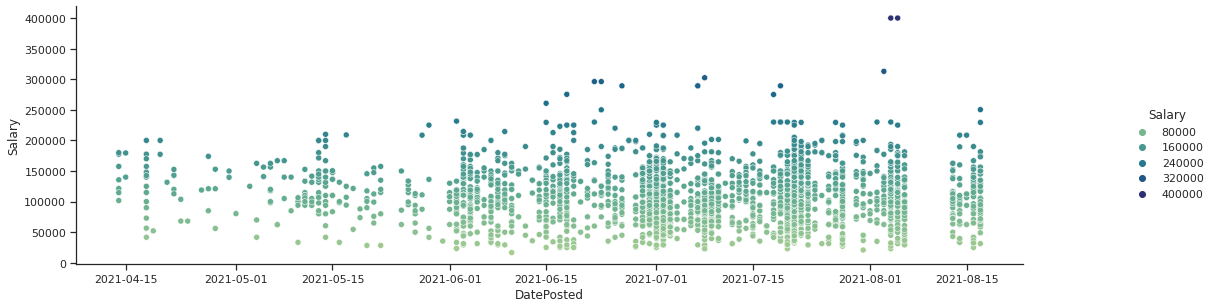

In [9]:
ax = sns.pairplot(data=munged[munged.Salary.notnull()],
                  x_vars=['DatePosted'],
                  y_vars=['Salary'], height=8, hue="Salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [10]:
outliers = []
def z_detect(munged):
    sample = munged[munged['Salary'].notnull()].Salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

[296171.4285714286,
 250000.0,
 296171.4285714286,
 289200.0,
 275314.28571428574,
 260714.28571428574,
 302428.5714285714,
 289200.0,
 274997.0,
 289200.0,
 289200.0,
 400000.0,
 400000.0,
 312857.14285714284,
 250285.71428571426]

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [11]:
def iqr_detect(munged):
    sample = munged[munged['Salary'].notnull()].Salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
iqr_detect(munged)

[296171.4285714286,
 250000.0,
 296171.4285714286,
 289200.0,
 275314.28571428574,
 260714.28571428574,
 302428.5714285714,
 289200.0,
 274997.0,
 289200.0,
 289200.0,
 400000.0,
 400000.0,
 312857.14285714284,
 250285.71428571426,
 229428.57142857142,
 230000.0,
 296171.4285714286,
 250000.0,
 296171.4285714286,
 289200.0,
 275314.28571428574,
 229428.57142857142,
 260714.28571428574,
 231500.0,
 302428.5714285714,
 289200.0,
 229428.57142857142,
 230000.0,
 274997.0,
 230000.0,
 230000.0,
 230000.0,
 289200.0,
 289200.0,
 229428.57142857142,
 229428.57142857142,
 230000.0,
 400000.0,
 400000.0,
 230000.0,
 312857.14285714284,
 250285.71428571426,
 229428.57142857142]

In [12]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

The 13 Unique Outliers Are:
400000.0
260714.28571428574
296171.4285714286
231500.0
250285.71428571426
250000.0
289200.0
275314.28571428574
230000.0
229428.57142857142
274997.0
312857.14285714284
302428.5714285714
- With a minumum of $229429 and a maximum of $400000


In [13]:
# Take a look at those tables.

outliers = munged[munged['Salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

,Company,JobTitle,Location,Requirements,Summary,Description,JobUrl,Salary,State,City,DatePosted,Schedule,Role,Focus
2918,pilgrim's,ecommerce sr analyst,"Greeley, CO 80634",none,drive retailers strategy from data source and ...,pilgrim’s is the second largest chicken produc...,https://www.indeed.com/rc/clk?jk=c7f45f5f8d3ac...,229428.571429,CO,greeley,2021-07-01,hour,data analyst,senior
3432,indeed,director of engineering- data science/ analyti...,Remote•Remote,none,data science and machine learning your team w...,none,https://www.indeed.com/rc/clk?jk=6c6ac03e68a95...,230000.000000,Remote,remote•remote,2021-06-22,year,data scientist,analysis
3712,salesforce,"senior engineering manager, augmented analytics","Seattle, WA",none,salesforce com and salesforce org will not pay...,to get the best candidate experience please c...,https://www.indeed.com/rc/clk?jk=459ecdd073282...,296171.428571,WA,seattle,2021-06-22,hour,data engineer,senior
5253,zocdoc,"senior manager, digital marketing analytics (dtc)","New York, NY 10016 (Gramercy area)",none,it's good if you have knowledge and ability to...,are you coming from an in house role at a d2c ...,https://www.indeed.com/rc/clk?jk=96b6f6cb0708e...,250000.000000,NY,new york,2021-06-23,year,data analyst,senior
5484,salesforce,"senior engineering manager, augmented analytics","Seattle, WA",none,salesforce com and salesforce org will not pay...,to get the best candidate experience please c...,https://www.indeed.com/rc/clk?jk=459ecdd073282...,296171.428571,WA,seattle,2021-06-23,hour,data engineer,senior
5491,nordstrom,senior software engineer - nordstrom analytica...,"Seattle, WA",none,bachelor's or master's in computer science en...,senior software engineer nordstrom analytica...,https://www.indeed.com/rc/clk?jk=1f479854e2f48...,289200.000000,WA,seattle,2021-06-26,year,data engineer,senior
5823,braintrust,sr. data engineer (no c2c),"San Francisco, CA",none,bachelor’s or advanced degree in information t...,job type freelance contract position no ag...,https://www.indeed.com/rc/clk?jk=6bb716e4fc203...,275314.285714,CA,san francisco,2021-06-18,hour,data engineer,senior
6744,braintrust,ml data engineer (no c2c!),"San Francisco, CA",none,experience working with event data in a data l...,job type freelance contract position no ag...,https://www.indeed.com/rc/clk?jk=0391b8a723774...,229428.571429,CA,san francisco,2021-06-15,hour,data scientist,machine learning
7176,automated capital management,full stack developer,Remote,aws: 3 years (required)python: 5 years (requir...,implement data pipelines that import and aggre...,full stack python django developer automated c...,https://www.indeed.com/company/Automated-Capit...,260714.285714,Remote,remote,2021-06-15,hour,Other,
8208,ibm,"strategy and transformation leader, watson hea...","Austin, TX",none,ibm provides you with the most comprehensive a...,introductionas a strategy consultant at ibm y...,https://www.indeed.com/rc/clk?jk=b8f7af7c78f35...,231500.000000,TX,austin,2021-06-02,year,Other,senior


In [14]:
null = len(munged[munged.Salary.isnull()])
nnull = len(munged[munged.Salary.notnull()])

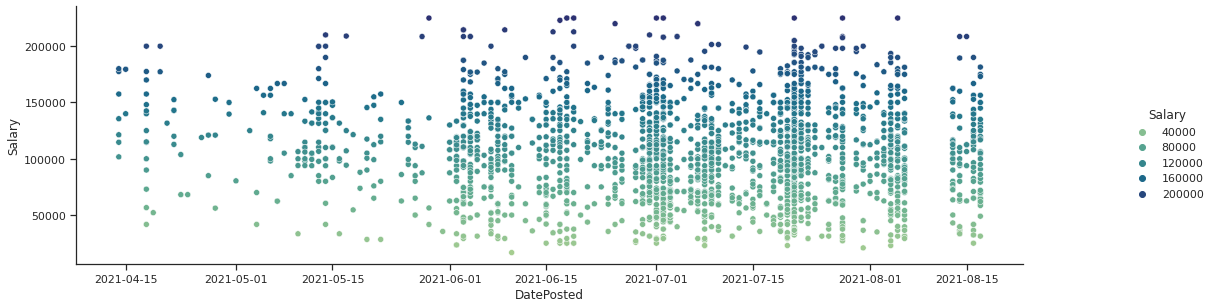

In [15]:
ax = sns.pairplot(data=munged[munged.Salary.notnull()],
                  x_vars=['DatePosted'],
                  y_vars=['Salary'], height=8, hue="Salary", palette="crest")

ax.fig.set_size_inches(18,4)

- Dropping 29 outliers now leaves 2406, or 9.47%, of rows with with salary information,
- The remaining 22990 rows, or 90.53%, are missing salary data.


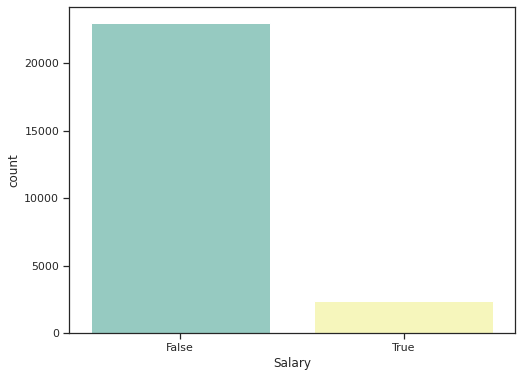

In [16]:
sns.countplot(x='Salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [17]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25396 entries, 0 to 25424
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Company       25396 non-null  object        
 1   JobTitle      25396 non-null  object        
 2   Location      25396 non-null  object        
 3   Requirements  25396 non-null  object        
 4   Summary       25396 non-null  object        
 5   Description   25396 non-null  object        
 6   JobUrl        25396 non-null  object        
 7   Salary        2406 non-null   float64       
 8   State         25396 non-null  object        
 9   City          25396 non-null  object        
 10  DatePosted    25396 non-null  datetime64[ns]
 11  Schedule      2510 non-null   object        
 12  Role          25396 non-null  object        
 13  Focus         25396 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(12)
memory usage: 3.9+ MB


In [18]:
munged.to_csv(f'../app/data/munged_data.csv', index=False)